In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve,auc

KeyboardInterrupt: 

In [ ]:
# Load the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print(train.shape,test.shape)
train["data"]="train"
test["data"]="test"
target="Response"
#test[target]=-1
data=pd.concat([train,test]).reset_index(drop=True)


(11504798, 12) (7669866, 11)


In [ ]:

def new_features(data_input):
    cat_col=["Gender","Driving_License","Region_Code",
            "Previously_Insured","Vehicle_Age","Vehicle_Damage","Policy_Sales_Channel",
            ]
    num_col=["Age","Annual_Premium","Vintage"]
    df=data_input.copy()
    # cat_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
    # df[cat_features] = df[cat_features].astype('category')
    # df["Vehicle_Age"] = df["Vehicle_Age"].cat.rename_categories({"1-2 Year": 1, "< 1 Year": 0, "> 2 Years": 2}).astype('int8')
    # df['Gender'] = df['Gender'].cat.rename_categories({'Male': 0, 'Female': 1}).astype('int8')
    # df['Vehicle_Damage'] = df['Vehicle_Damage'].cat.rename_categories({'No': 0, 'Yes': 1}).astype('int8')
    label_encoders = {}
    for col in cat_col:
        le= LabelEncoder()
        df[col] = le.fit_transform(df[col])
    for col in cat_col+num_col:
        ss=StandardScaler()
        #print(col)
        df[col]=ss.fit_transform(df[[col]])
    return df
data_new_feature=new_features(data)

In [ ]:
df_train=data_new_feature[data_new_feature["data"]=="train"].drop(columns=["data"])
df_test=data_new_feature[data_new_feature["data"]=="test"].drop(columns=["data",'Response'])

In [ ]:
# Separate features and target
X = df_train.drop(columns=['Response',"id"])
y = df_train['Response']


In [ ]:
X_input=X.head(10000).copy()
y_input=y.head(10000).copy()
test_input=df_test.head(10000).copy().drop(columns=["id"])
n_splits=2


# model1 

In [ ]:
from tensorflow.keras.metrics import AUC
from sklearn.metrics import auc as auc_calc
def fit_kfold(X_input,y_input,test_input,n_splits=5):
    # GroupKFoldの初期化
    accuracies = []
    oof_predictions = np.zeros([X.shape[0]])
    oof_test = np.zeros((test_input.shape[0], n_splits))
    aucs = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    history={}
    # 各分割のデータインデックスを出力
    for fold, (train_idx, val_index) in enumerate(skf.split(X_input, y_input)):
        print(f"Fold {fold + 1}")
        # データを分割
        X_train, X_val = X_input.iloc[train_idx], X_input.iloc[val_index]
        y_train, y_val = y_input.iloc[train_idx], y_input.iloc[val_index]
        #Kerasモデルの構築
        model = Sequential()
        model.add(Dense(256, activation='relu', input_dim=X_input.shape[1]))
        #model.add(Dropout(0.5))
        #model.add(Dense(128, activation='relu'))
        #model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))  
        #model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        
        # モデルのコンパイル（accuracyをメトリクスとして指定）
        model.compile(optimizer=Adam(learning_rate=0.03),
                    loss='binary_crossentropy',
                    metrics=[AUC(name='auc',curve="roc")])

        # 早期終了のコールバックを設定
        early_stopping = EarlyStopping(monitor='val_auc_roc', patience=10, mode='max', restore_best_weights=True)
        history=dict()
        # # モデルの学習
        history = model.fit(X_train, y_train, epochs=100, batch_size=4096, verbose=1,
                            validation_data=(X_val, y_val),callbacks=[early_stopping])

        # 予測
        y_pred = model.predict(X_val)
        auc_score = roc_auc_score(y_val, y_pred)
        if fold==0:
            # 学習曲線のプロット
            plt.figure(figsize=(10, 6))
            plt.plot(history.history['auc'], label='Train AUC')
            plt.plot(history.history['val_auc'], label='Validation AUC')
            plt.xlabel('Epochs')
            plt.ylabel('AUC')
            plt.title('AUC Learning Curve')
            plt.legend()
            plt.show()

                # ROC曲線を計算
            fpr, tpr, thresholds = roc_curve(y_val, y_pred)

            # AUCを計算
            roc_auc = auc_calc(fpr, tpr)

            # ROC曲線をプロット
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()
    return oof_predictions,oof_test


Fold 1
Epoch 1/100
1405/1405 [==============================] - 8s 5ms/step - loss: 0.2666 - auc: 0.8543 - val_loss: 0.2649 - val_auc: 0.8570
Epoch 2/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2647 - auc: 0.8573 - val_loss: 0.2655 - val_auc: 0.8573
Epoch 3/100
1405/1405 [==============================] - 8s 6ms/step - loss: 0.2644 - auc: 0.8580 - val_loss: 0.2644 - val_auc: 0.8583
Epoch 4/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2642 - auc: 0.8584 - val_loss: 0.2642 - val_auc: 0.8586
Epoch 5/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2641 - auc: 0.8586 - val_loss: 0.2644 - val_auc: 0.8582
Epoch 6/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2639 - auc: 0.8589 - val_loss: 0.2642 - val_auc: 0.8590
Epoch 7/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2638 - auc: 0.8591 - val_loss: 0.2641 - val_auc: 0.8587
Epoch 8/100
1405/1405 [=========================

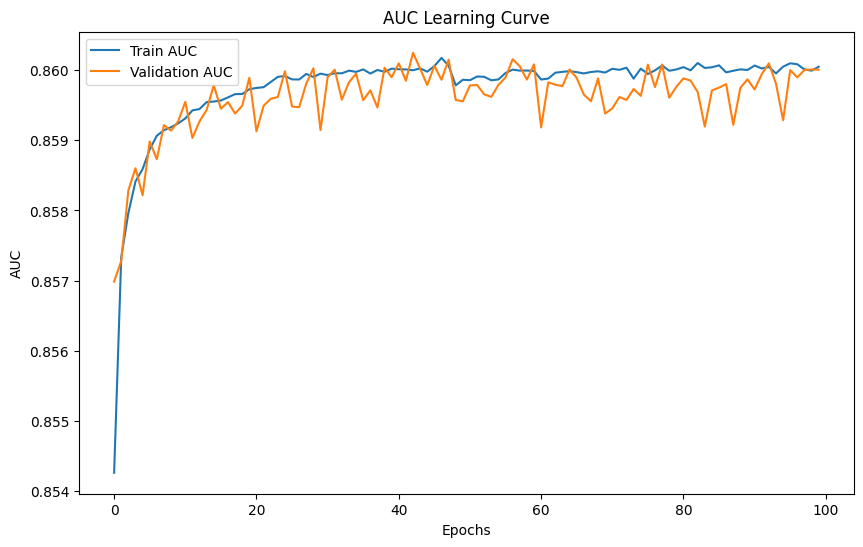

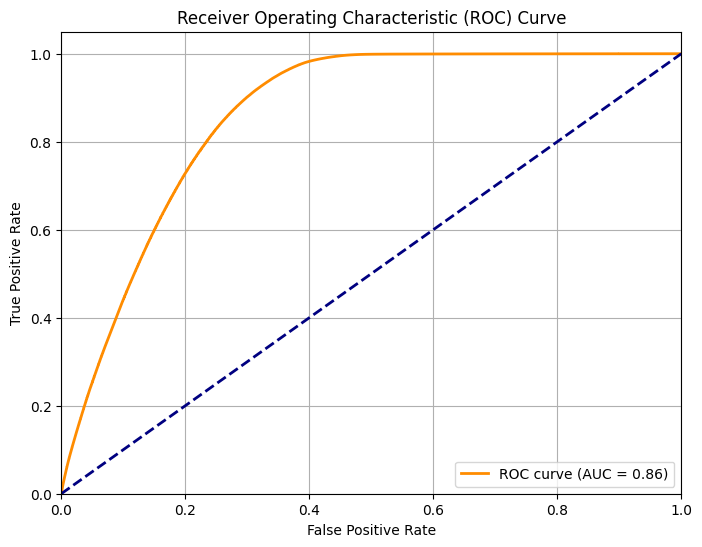

Fold 2
Epoch 1/100
1405/1405 [==============================] - 8s 5ms/step - loss: 0.2667 - auc: 0.8540 - val_loss: 0.2653 - val_auc: 0.8578
Epoch 2/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2649 - auc: 0.8570 - val_loss: 0.2642 - val_auc: 0.8586
Epoch 3/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2646 - auc: 0.8576 - val_loss: 0.2641 - val_auc: 0.8593
Epoch 4/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2644 - auc: 0.8580 - val_loss: 0.2636 - val_auc: 0.8594
Epoch 5/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2644 - auc: 0.8582 - val_loss: 0.2638 - val_auc: 0.8590
Epoch 6/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2643 - auc: 0.8583 - val_loss: 0.2640 - val_auc: 0.8588
Epoch 7/100
1405/1405 [==============================] - 7s 5ms/step - loss: 0.2642 - auc: 0.8584 - val_loss: 0.2644 - val_auc: 0.8595
Epoch 8/100
1405/1405 [=========================

In [ ]:
test_x=df_test.copy().drop(columns=["id"])
oof_pred,oof_test=fit_kfold(X, y,test_x,n_splits=2)

In [ ]:
df_oof_train=pd.DataFrame(oof_pred,columns=["y_pred_keras"])
df_oof_train.to_csv(r"y_pred_train_keras.csv")

In [ ]:
df_oof_test=pd.DataFrame(np.mean(oof_test,axis=1),columns=["y_pred_keras"])
df_oof_test.to_csv(r"y_pred_test_keras.csv")

In [ ]:
df_oof_train.shape

(80942, 3)

In [ ]:
df_oof_test.shape

(51012, 3)